In [1]:
!pip install --upgrade pip
!pip3 install tensorflow
!pip install gym
!pip install keras
!pip install keras-rl2
!pip3 install flask

In [1]:
#RL libraries
from gym import Env
from gym.spaces import Discrete, Box
from rl.agents import DQNAgent
from rl.policy import BoltzmannQPolicy
from rl.memory import SequentialMemory

#Neural network libraries
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.optimizers import Adam

#Math libraries
import numpy as np
import random
import math
import matplotlib.pyplot as plt

In [51]:
class WindmillEnv(Env):
    def __init__(self):
        
        #Set action space
        self.action_space = Discrete(3)
        
        #Set observation space
        self.observation_space = Box(low=np.array([5]), high=np.array([14]))
        
        #Set training time
        self.training_length = 100
        
        #SET WINDMILL PARAMETERS
        #Static parameters
        self.wind_density = 1.225
        self.radious = 2
        self.powerRef = 2000.0
        
        #Dynamic parameters
        self.angle = random.uniform(5, 14)
        self.wind = 10.0
        self.error = 0.0
        self.power_eficiency = -0.0422*self.angle + 0.5911
        self.genPowerEuler = 0.5*self.wind_density*math.pi*pow(self.radious, 2)*pow(self.wind, 3)*self.power_eficiency
        
        
    def step(self, action):
        #Save the error from the previous step in a variable
        last_error = self.error
        
        #Reduces training time in 1 second
        self.training_length -= 1
        
        #Apply action
            #0.0 - 0.1 = -0.1 (angle reduces in 0.1)
            #0.1 - 0.1 = 0.0 (angle does not change)
            #0.2 - 0.1 = 0.1 (angle increases in 0.1)
        self.angle += (action/10.0) - 0.1 #AÑADIR MAS ACCIONES
        
        #Euler for Calculating energy
        for t in range(1, 151):
            self.power_eficiency = -0.0422*self.angle + 0.5911
            self.genPowerEuler += ((0.5*self.wind_density*math.pi*pow(self.radious, 2)*pow(self.wind, 3)*self.power_eficiency)/5 - self.genPowerEuler/5)*0.5
            if self.genPowerEuler > (self.powerRef - 1.0) and self.genPowerEuler < (self.powerRef + 1.0):
                break
        
        #Calculates final error
        self.error = abs(self.powerRef - self.genPowerEuler)
        
        #Calculates reward
        if self.error < last_error:
            reward = 10
        elif self.error == last_error:
            reward = -1
        else:
            reward = -10
        
        #Check if the training finished
        if self.training_length <= 0 or self.error <= 1.0:
            done = True
        else:
            done = False
            
        #Wind disturbances
        #self.wind += random.uniform(-0.1,0.1)
        
        #placeholder for the info
        info = {}
        
        #Return step information
        return self.angle, reward, done, info
    
    def reset(self):
        #Reset parameters
        self.angle = random.uniform(5, 14)
        self.wind = 10.0
        self.power_eficiency = -0.0422*self.angle + 0.5911
        self.genPowerEuler = 0.5*self.wind_density*math.pi*pow(self.radious, 2)*pow(self.wind, 3)*self.power_eficiency
        
        #Reset training time
        self.training_length = 100
        
        return self.angle

In [52]:
env = WindmillEnv()

Episode:1 Score:27 Angle:7.808991617533904


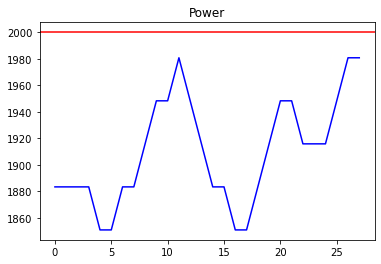

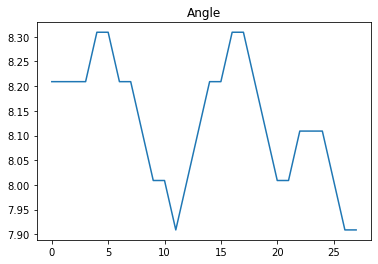

Episode:2 Score:29 Angle:13.733374424927659


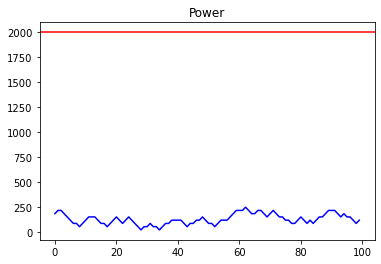

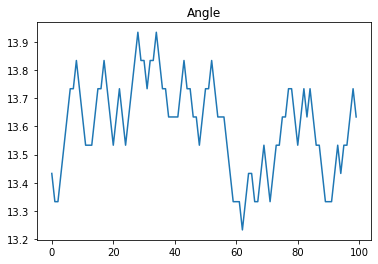

Episode:3 Score:-55 Angle:11.756104386903258


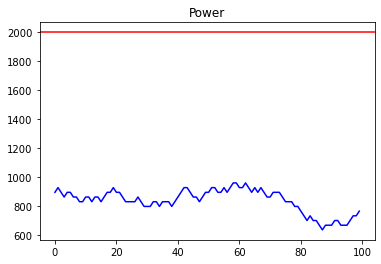

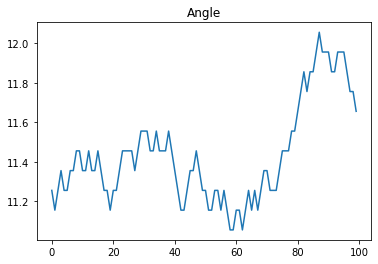

Episode:4 Score:28 Angle:7.770565016847872


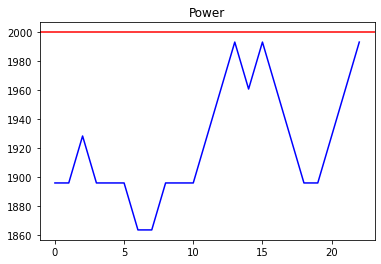

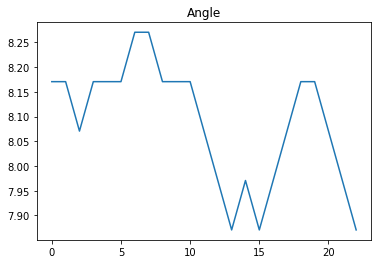

Episode:5 Score:-85 Angle:9.734605746953621


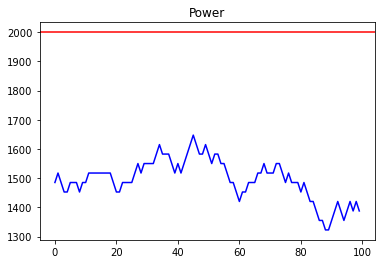

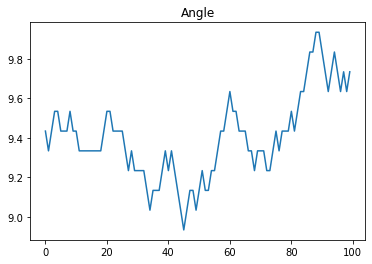

Episode:6 Score:-64 Angle:13.253032002817209


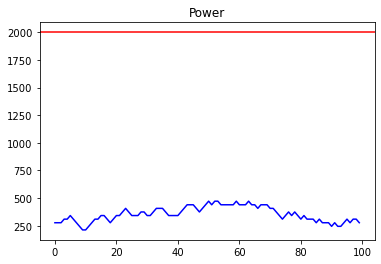

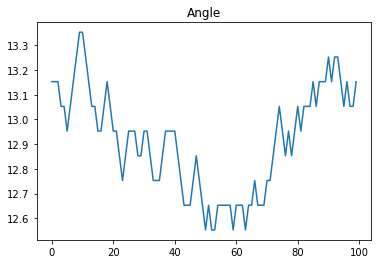

Episode:7 Score:-172 Angle:11.725675368696779


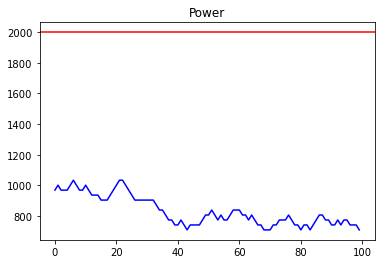

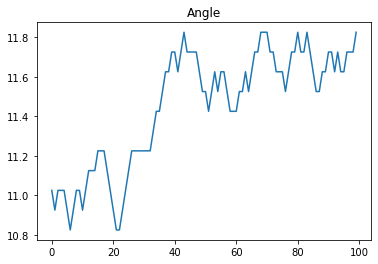

Episode:8 Score:-170 Angle:11.01308624166536


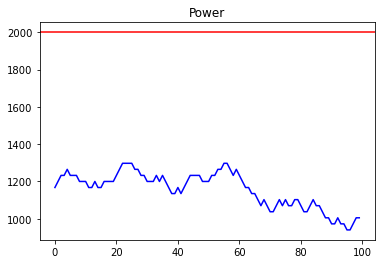

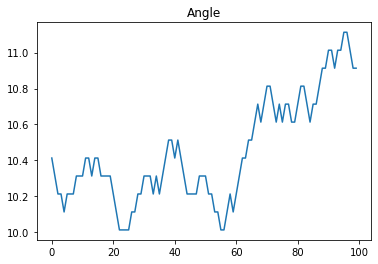

Episode:9 Score:56 Angle:11.31621802473916


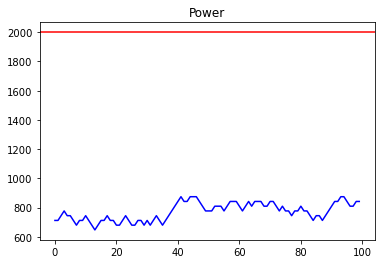

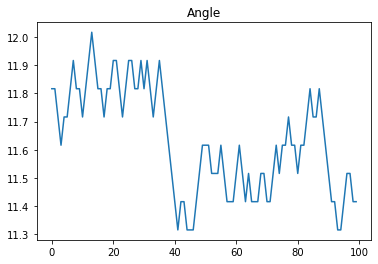

Episode:10 Score:101 Angle:7.331606937461256


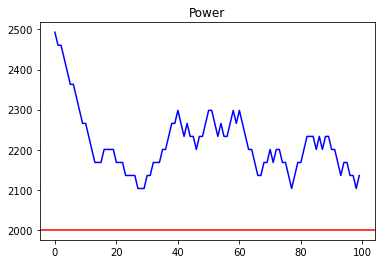

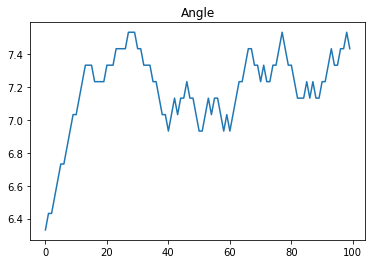

In [53]:
episodes = 10

for episode in range(1, episodes+1):
    action = env.reset()
    done = False
    score = 0
    powerArray = []
    anglesArray = []
    refPower = env.powerRef
    
    while not done:
        powerArray.append(env.genPowerEuler)
        anglesArray.append(env.angle)
        
        action = env.action_space.sample()
        n_state, reward, done, info = env.step(action)
        score += reward
    print('Episode:{} Score:{} Angle:{}'.format(episode, score, n_state))
    
    plt.title("Power"), plt.axhline(y=refPower, color='r', linestyle='-')
    plt.plot(powerArray, 'b')
    plt.show()
    
    plt.title("Angle"), plt.plot(anglesArray)
    plt.show()

In [54]:
states = env.observation_space.shape
actions = env.action_space.n

In [55]:
def build_model(states, actions):
    model = Sequential()
    model.add(Dense(28, activation='relu', input_shape = states))
    model.add(Dense(28, activation='relu'))
    model.add(Dense(actions, activation='linear'))
    return model

In [56]:
model = build_model(states, actions)

In [57]:
def build_agent(model, actions):
    policy = BoltzmannQPolicy()
    memory = SequentialMemory(limit=50000, window_length=1)
    dqn = DQNAgent(model=model, memory=memory, policy=policy, nb_actions=actions, nb_steps_warmup=10, target_model_update=1e-2)
    return dqn

In [62]:
dqn = build_agent(model, actions)
dqn.compile(Adam(lr=1e-3), metrics=['mae'])
dqn.fit(env, nb_steps=100000, visualize=False, verbose=1)

Training for 100000 steps ...
Interval 1 (0 steps performed)
10000/10000 [==============================] - 84s 8ms/step - reward: 4.9868
202 episodes - episode_reward: 246.228 [-44.000, 597.000] - loss: 60.861 - mae: 85.135 - mean_q: 155.057

Interval 2 (10000 steps performed)
10000/10000 [==============================] - 84s 8ms/step - reward: 6.4598
259 episodes - episode_reward: 248.100 [-231.000, 597.000] - loss: 18.557 - mae: 58.103 - mean_q: 118.222

Interval 3 (20000 steps performed)
10000/10000 [==============================] - 94s 9ms/step - reward: 6.6694
262 episodes - episode_reward: 256.351 [-50.000, 600.000] - loss: 18.717 - mae: 59.172 - mean_q: 121.333

Interval 4 (30000 steps performed)
10000/10000 [==============================] - 96s 10ms/step - reward: 5.1122
231 episodes - episode_reward: 221.351 [-54.000, 600.000] - loss: 16.428 - mae: 52.925 - mean_q: 117.986

Interval 5 (40000 steps performed)
10000/10000 [==============================] - 88s 9ms/step - rew

In [63]:
scores = dqn.test(env, nb_episodes=10, visualize=False)
print(np.mean(scores.history['episode_reward']))

Testing for 10 episodes ...
Episode 1: reward: 21.000, steps: 100
Episode 2: reward: 1.000, steps: 100
Episode 3: reward: 23.000, steps: 100
Episode 4: reward: 485.000, steps: 100
Episode 5: reward: 210.000, steps: 100
Episode 6: reward: 496.000, steps: 100
Episode 7: reward: 166.000, steps: 100
Episode 8: reward: 67.000, steps: 100
Episode 9: reward: 45.000, steps: 100
Episode 10: reward: 155.000, steps: 100
166.9


30.253474678782823
147.37749423040668
114.89656778494236
82.41564133947759
49.93471489401327
17.453788448548266
17.453784002186694
17.453784002186694
17.453784002186694
17.453784002186694
17.453784002186694
17.453784002186694
17.453784002186694
17.453784002186694
17.453784002186694
17.453784002186694
17.453784002186694
17.453784002186694
17.453784002186694
17.453784002186694
17.453784002186694
17.453784002186694
17.453784002186694
17.453784002186694
17.453784002186694
17.453784002186694
17.453784002186694
17.453784002186694
17.453784002186694
17.453784002186694
17.453784002186694
17.453784002186694
17.453784002186694
17.453784002186694
17.453784002186694
17.453784002186694
17.453784002186694
17.453784002186694
17.453784002186694
17.453784002186694
17.453784002186694
17.453784002186694
17.453784002186694
17.453784002186694
17.453784002186694
17.453784002186694
17.453784002186694
17.453784002186694
17.453784002186694
17.453784002186694
17.453784002186694
17.453784002186694
17.45378400218

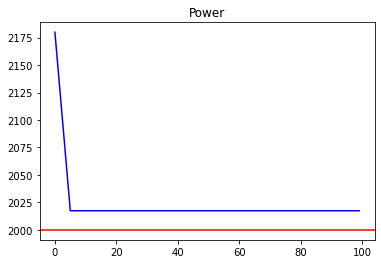

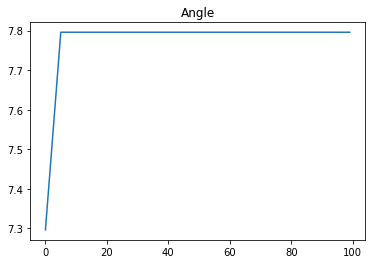

17.453784002186694
771.2200916541983
738.739165208734
706.2582387632692
673.7773123178049
641.2963858723401
608.8154594268749
576.3345329814106
543.8536065359458
511.372680090481
478.89175364501625
446.4108271995515
413.9299007540867
381.4489743086219
348.96804786315715
316.4871214176924
284.0061949722276
251.52526852676283
219.04434208129805
186.56341563583328
154.08248919036896
121.60156274490373
89.12063629943896
56.63970985397418
24.158783408509635
24.158778962148062
24.158778962148062
24.158778962148062
24.158778962148062
24.158778962148062
24.158778962148062
24.158778962148062
24.158778962148062
24.158778962148062
24.158778962148062
24.158778962148062
24.158778962148062
24.158778962148062
24.158778962148062
24.158778962148062
24.158778962148062
24.158778962148062
24.158778962148062
24.158778962148062
24.158778962148062
24.158778962148062
24.158778962148062
24.158778962148062
24.158778962148062
24.158778962148062
24.158778962148062
24.158778962148062
24.158778962148062
24.15877896

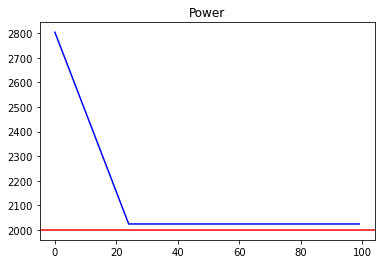

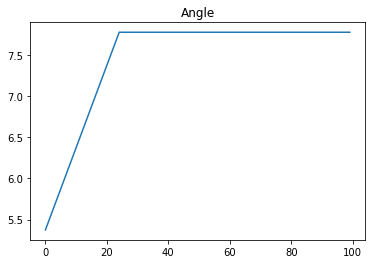

24.158778962148062
975.1059010057229
942.6249745602584
910.144048114794
877.6631216693293
845.182195223864
812.7012687783997
780.2203423329349
747.7394158874702
715.2584894420049
682.7775629965406
650.2966365510758
617.8157101056111
585.3347836601467
552.8538572146815
520.3729307692167
487.89200432375196
455.4110778782872
422.93015143282287
390.44922498735764
357.96829854189286
325.4873720964281
293.0064456509633
260.525519205499
228.04459276003377
195.563666314569
163.08273986910422
130.6018134236399
98.12088697817512
65.63996053270989
33.15903408724557
33.159029640884
33.159029640884
33.159029640884
33.159029640884
33.159029640884
33.159029640884
33.159029640884
33.159029640884
33.159029640884
33.159029640884
33.159029640884
33.159029640884
33.159029640884
33.159029640884
33.159029640884
33.159029640884
33.159029640884
33.159029640884
33.159029640884
33.159029640884
33.159029640884
33.159029640884
33.159029640884
33.159029640884
33.159029640884
33.159029640884
33.159029640884
33.1590

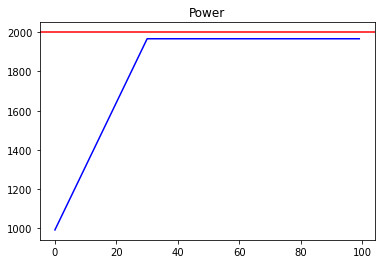

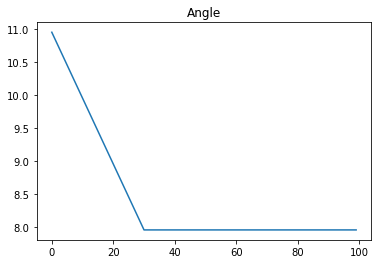

33.159029640884
30.42302210040316
30.42302210040316
30.42302210040316
30.42302210040316
30.42302210040316
30.42302210040316
30.42302210040316
30.42302210040316
30.42302210040316
30.42302210040316
30.42302210040316
30.42302210040316
30.42302210040316
30.42302210040316
30.42302210040316
30.42302210040316
30.42302210040316
30.42302210040316
30.42302210040316
30.42302210040316
30.42302210040316
30.42302210040316
30.42302210040316
30.42302210040316
30.42302210040316
30.42302210040316
30.42302210040316
30.42302210040316
30.42302210040316
30.42302210040316
30.42302210040316
30.42302210040316
30.42302210040316
30.42302210040316
30.42302210040316
30.42302210040316
30.42302210040316
30.42302210040316
30.42302210040316
30.42302210040316
30.42302210040316
30.42302210040316
30.42302210040316
30.42302210040316
30.42302210040316
30.42302210040316
30.42302210040316
30.42302210040316
30.42302210040316
30.42302210040316
30.42302210040316
30.42302210040316
30.42302210040316
30.42302210040316
30.423022100

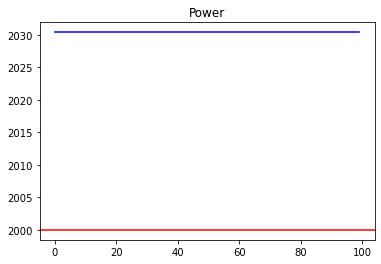

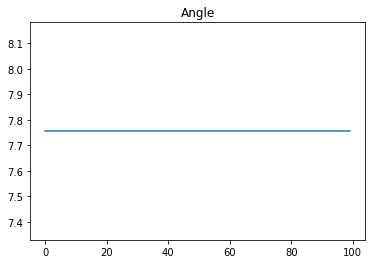

30.42302210040316
513.4896069020815
481.0086804566172
448.5277540111524
416.0468275656881
383.5659011202233
351.0849746747581
318.6040482292933
286.123121783829
253.64219533836422
221.161268892899
188.68034244743467
156.1994160019699
123.71848955650466
91.23756311103989
58.75663666557557
26.275710220110568
26.275705773748996
26.275705773748996
26.275705773748996
26.275705773748996
26.275705773748996
26.275705773748996
26.275705773748996
26.275705773748996
26.275705773748996
26.275705773748996
26.275705773748996
26.275705773748996
26.275705773748996
26.275705773748996
26.275705773748996
26.275705773748996
26.275705773748996
26.275705773748996
26.275705773748996
26.275705773748996
26.275705773748996
26.275705773748996
26.275705773748996
26.275705773748996
26.275705773748996
26.275705773748996
26.275705773748996
26.275705773748996
26.275705773748996
26.275705773748996
26.275705773748996
26.275705773748996
26.275705773748996
26.275705773748996
26.275705773748996
26.275705773748996
26.27570

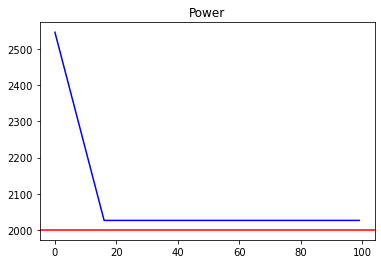

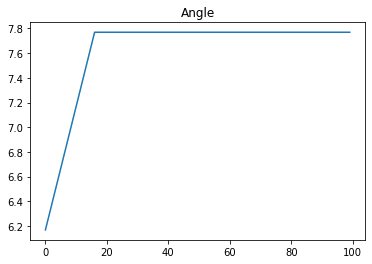

26.275705773748996
1722.4920047867145
1690.011078341251
1657.5301518957863
1625.0492254503215
1592.5682990048565
1560.0873725593915
1527.6064461139267
1495.125519668462
1462.6445932229979
1430.1636667775329
1397.682740332068
1365.2018138866033
1332.7208874411383
1300.2399609956733
1267.759034550209
1235.2781081047442
1202.7971816592797
1170.3162552138147
1137.8353287683499
1105.3544023228853
1072.8734758774203
1040.3925494319556
1007.9116229864907
975.4306965410262
942.9497700955615
910.4688436500962
877.9879172046319
845.5069907591671
813.0260643137019
780.5451378682371
748.0642114227728
715.583284977308
683.1023585318428
650.6214320863785
618.1405056409137
585.6595791954489
553.1786527499842
520.6977263045194
488.2167998590546
455.73587341358984
423.2549469681255
390.7740205226603
358.2930940771955
325.81216763173074
293.33124118626597
260.8503147408012
228.36938829533642
195.88846184987165
163.40753540440687
130.9266089589421
98.44568251347778
65.96475606801255
33.48382962254777
33.

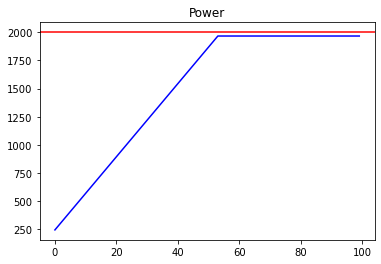

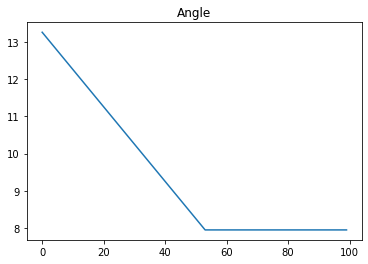

33.4838251761862
913.2586076976133
880.7776812521495
848.2967548066847
815.8158283612199
783.3349019157547
750.8539754702904
718.3730490248256
685.8921225793608
653.411196133896
620.9302696884317
588.4493432429665
555.9684167975017
523.487490352037
491.0065639065722
458.5256374611074
426.04471101564263
393.56378457017786
361.0828581247131
328.60193167924876
296.121005233784
263.64007878831876
231.15915234285444
198.67822589738967
166.19729945192444
133.71637300646012
101.23544656099534
68.75452011553057
36.27359367006534
36.273589223703766
36.273589223703766
36.273589223703766
36.273589223703766
36.273589223703766
36.273589223703766
36.273589223703766
36.273589223703766
36.273589223703766
36.273589223703766
36.273589223703766
36.273589223703766
36.273589223703766
36.273589223703766
36.273589223703766
36.273589223703766
36.273589223703766
36.273589223703766
36.273589223703766
36.273589223703766
36.273589223703766
36.273589223703766
36.273589223703766
36.273589223703766
36.27358922370376

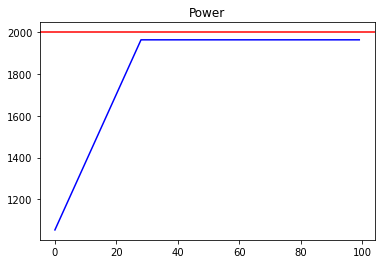

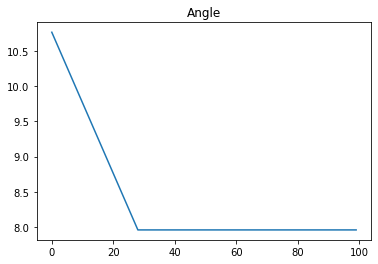

36.273589223703766
552.7032445350255
520.2223180895621
487.7413916440969
455.2604651986321
422.7795387531678
390.298612307703
357.8176858622378
325.336759416773
292.8558329713087
260.3749065258439
227.8939800803787
195.41305363491438
162.9321271894496
130.45120074398483
97.97027429852005
65.48934785305528
33.008421407590276
Episode:8 Score:160 Steps:18 Power:2000.9595776693695


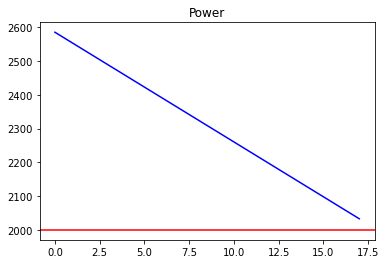

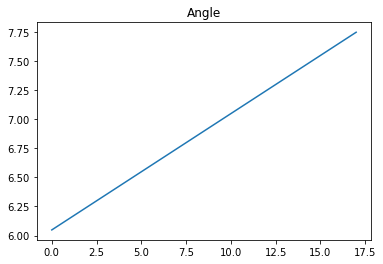

0.959577669369537
1528.8764145602552
1496.395488114792
1463.914561669327
1431.433635223862
1398.9527087783972
1366.4717823329324
1333.9908558874674
1301.5099294420024
1269.0290029965379
1236.548076551073
1204.0671501056088
1171.5862236601438
1139.105297214679
1106.6243707692145
1074.1434443237495
1041.6625178782847
1009.1815914328203
976.7006649873554
944.2197385418901
911.7388120964254
879.257885650961
846.7769592054963
814.296032760031
781.8151063145667
749.334179869102
716.8532534236372
684.3723269781719
651.8914005327076
619.4104740872428
586.9295476417781
554.4486211963133
521.9676947508485
489.48676830538375
457.005841859919
424.52491541445465
392.0439889689894
359.56306252352465
327.0821360780599
294.6012096325951
262.1202831871303
229.639356741666
197.15843029620078
164.677503850736
132.19657740527123
99.71565095980691
67.23472451434168
34.753798068876904
34.75379362251533
34.75379362251533
34.75379362251533
34.75379362251533
34.75379362251533
34.75379362251533
34.7537936225153

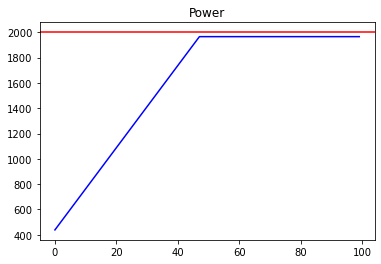

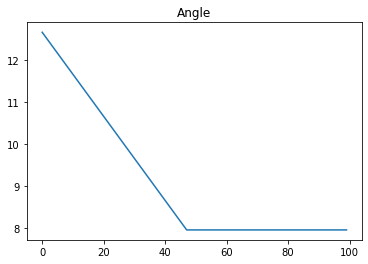

34.75379362251533
1698.8179428960966
1666.3370164506332
1633.8560900051682
1601.3751635597034
1568.8942371142384
1536.4133106687736
1503.9323842233086
1471.4514577778436
1438.9705313323798
1406.4896048869148
1374.0086784414498
1341.527751995985
1309.04682555052
1276.5658991050557
1244.084972659591
1211.604046214126
1179.1231197686616
1146.6421933231966
1114.1612668777316
1081.6803404322673
1049.1994139868025
1016.7184875413375
984.2375610958726
951.7566346504079
919.2757082049432
886.7947817594784
854.3138553140136
821.8329288685488
789.3520024230841
756.8710759776193
724.3901495321545
691.9092230866897
659.428296641225
626.9473701957606
594.4664437502954
561.9855173048306
529.5045908593663
497.0236644139011
464.54273796843677
432.06181152297154
399.5808850775072
367.099958632042
334.6190321865772
302.1381057411129
269.6571792956481
237.1762528501829
204.69532640471812
172.2143999592538
139.73347351378902
107.25254706832379
74.77162062285947
42.2906941773947
9.809767731929924
9.8097632

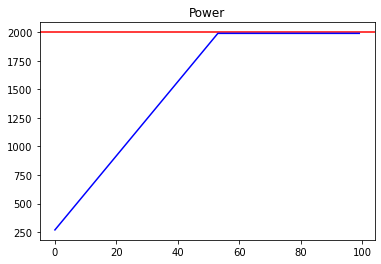

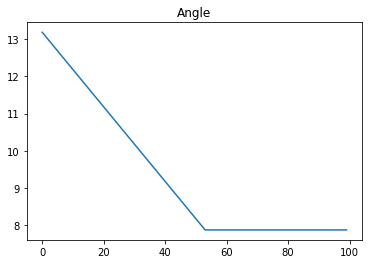

In [64]:
episodes = 10

for episode in range(1, episodes+1):
    obs = env.reset()
    done = False
    score = 0
    powerArray = []
    anglesArray = []
    refPower = env.powerRef
    initTrainingLenght = env.training_length
    
    while not done:
        powerArray.append(env.genPowerEuler)
        anglesArray.append(env.angle)
        print(env.error)
        action = dqn.forward(obs)
        obs, reward, done, info = env.step(action)
        score += reward
    print('Episode:{} Score:{} Steps:{} Power:{}'.format(episode, score, initTrainingLenght - env.training_length, env.genPowerEuler))
    
    plt.title("Power"), plt.axhline(y=refPower, color='r', linestyle='-')
    plt.plot(powerArray, 'b')
    plt.show()
    
    plt.title("Angle"), plt.plot(anglesArray)
    plt.show()